In [1]:
# ------------------ IMPORT LIBRARIES ------------------
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------  LOAD ALL STATES & CITIES DATA ------------------
base_path = "D:/MCA MINI PROJECT/cleaned_data"
dfs = []

for state in os.listdir(base_path):
    state_path = os.path.join(base_path, state)
    if os.path.isdir(state_path):
        for city_file in os.listdir(state_path):
            if city_file.endswith(".csv"):
                file_path = os.path.join(state_path, city_file)
                df_temp = pd.read_csv(file_path)
                dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)

# ------------------ BASIC DATA CHECK ------------------
print(df.columns) # return column name
print(df.head()) # return 5 record
print(df.info()) #give dataset info

# ------------------  DATE & TIME PROCESSING ------------------
df["TIMESTAMP"] = pd.to_datetime(
    df["TIMESTAMP"],
    errors="coerce",      # invalid dates -> NaT
    dayfirst=True,        # handles 1/1/2024 correctly
    format="mixed"        # handles mixed formats
)
df = df.dropna(subset=["TIMESTAMP"])
df["Year"] = df["TIMESTAMP"].dt.year
df["Month_Num"] = df["TIMESTAMP"].dt.month


Index(['TIMESTAMP', 'PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 'MONTH',
       'SEASON', 'FESTIVAL_SEASON', 'AQI', 'AQI_CATEGORY', 'CITY', 'STATE',
       'LATITUDE', 'LONGITUDE'],
      dtype='object')
             TIMESTAMP   PM2.5    PM10    NO2    NH3    SO2    CO     O3  \
0  2024-01-01 00:00:00  166.25  233.75  17.80  13.98  13.70  1.06   8.78   
1  2024-01-01 01:00:00  160.50  216.50  14.22  15.15  14.10  0.94  10.55   
2  2024-01-01 02:00:00  138.00  182.75  12.45  16.10  13.85  0.87  13.05   
3  2024-01-01 03:00:00  130.00  176.75  10.85  16.32  14.70  0.92  12.60   
4  2024-01-01 04:00:00  128.00  175.25   8.90  16.73  14.15  0.82  10.40   

     MONTH  SEASON       FESTIVAL_SEASON         AQI AQI_CATEGORY      CITY  \
0  January  Winter  Christmas & New Year  335.726744    Very Poor  Amravati   
1  January  Winter  Christmas & New Year  331.313953    Very Poor  Amravati   
2  January  Winter  Christmas & New Year  314.046512    Very Poor  Amravati   
3  January  Winte

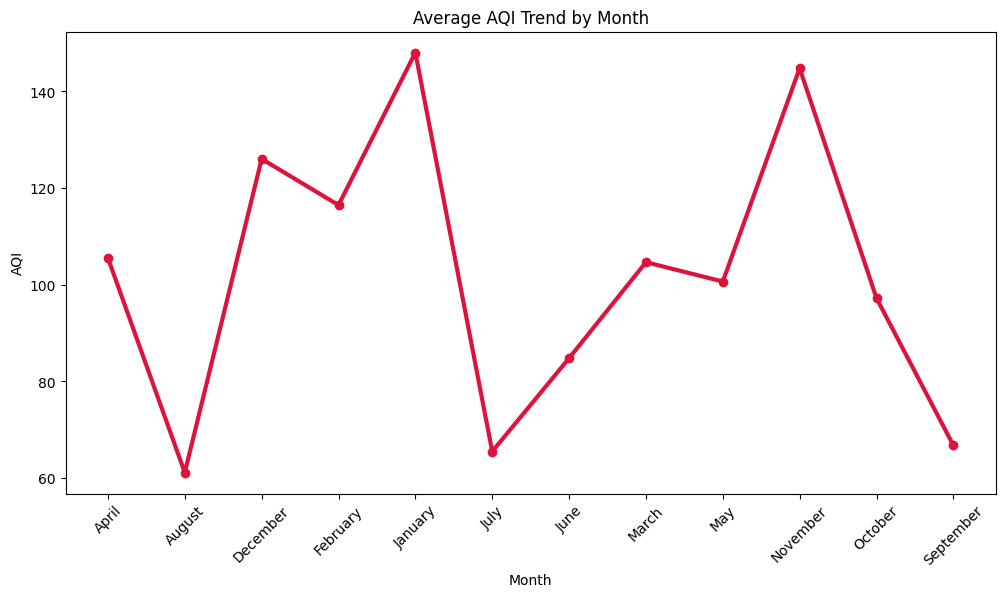

In [2]:
# ------------------ MONTH-WISE AQI TREND ------------------
month_avg = df.groupby("MONTH")["AQI"].mean()
plt.figure(figsize=(12,6))
plt.plot(month_avg.index, month_avg.values, marker='o', color='crimson', linewidth=3)
plt.title("Average AQI Trend by Month")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.show()

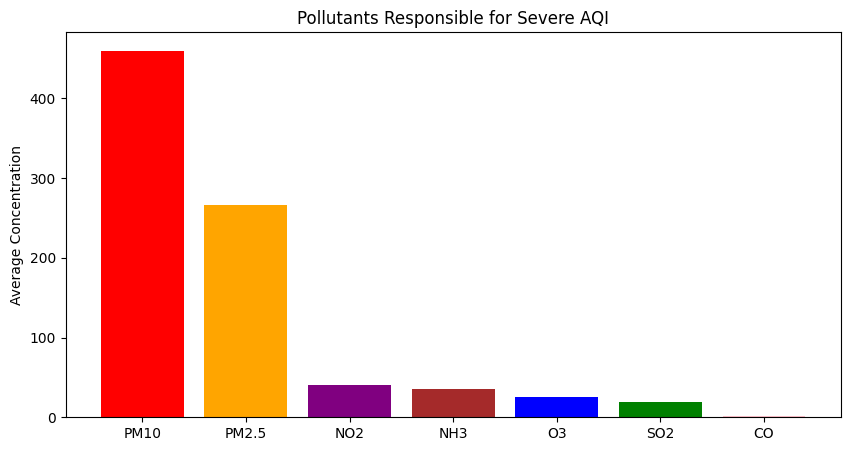

In [3]:
# ------------------ WORST POLLUTANT ------------------
pollutants = ["PM2.5", "PM10", "NO2", "NH3", "SO2", "CO", "O3"]
severe_df = df[df["AQI_CATEGORY"]=="Severe"]
avg_pollutants = severe_df[pollutants].mean().sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(avg_pollutants.index, avg_pollutants.values, color=['red','orange','purple','brown','blue','green','pink'])
plt.title("Pollutants Responsible for Severe AQI")
plt.ylabel("Average Concentration")
plt.show()

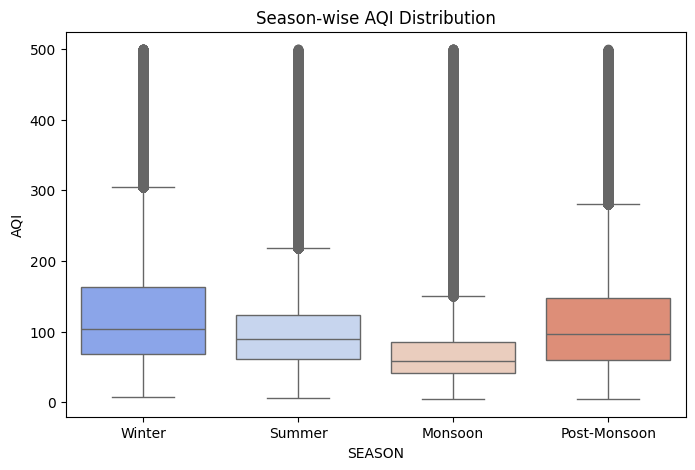

In [15]:
# ------------------ SEASON-WISE AQI (BOX PLOT) ------------------
plt.figure(figsize=(8,5))
sns.boxplot(
    data=df,
    x="SEASON",
    y="AQI",
    hue="SEASON",
    palette="coolwarm",
    legend=False
)
plt.title("Season-wise AQI Distribution")
plt.show()

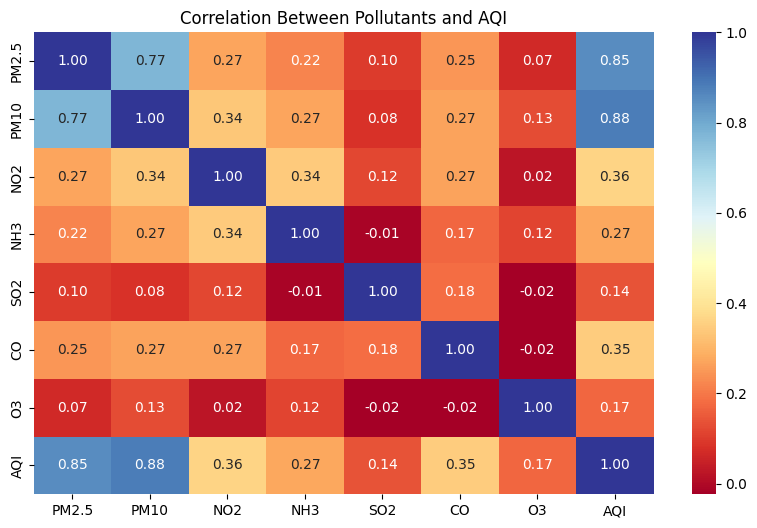

In [5]:
# ------------------ POLLUTANT vs AQI CORRELATION (HEATMAP) ------------------
plt.figure(figsize=(10,6))
sns.heatmap(
    df[pollutants + ["AQI"]].corr(),
    annot=True,
    cmap="RdYlBu",
    fmt=".2f"
)
plt.title("Correlation Between Pollutants and AQI")
plt.show()

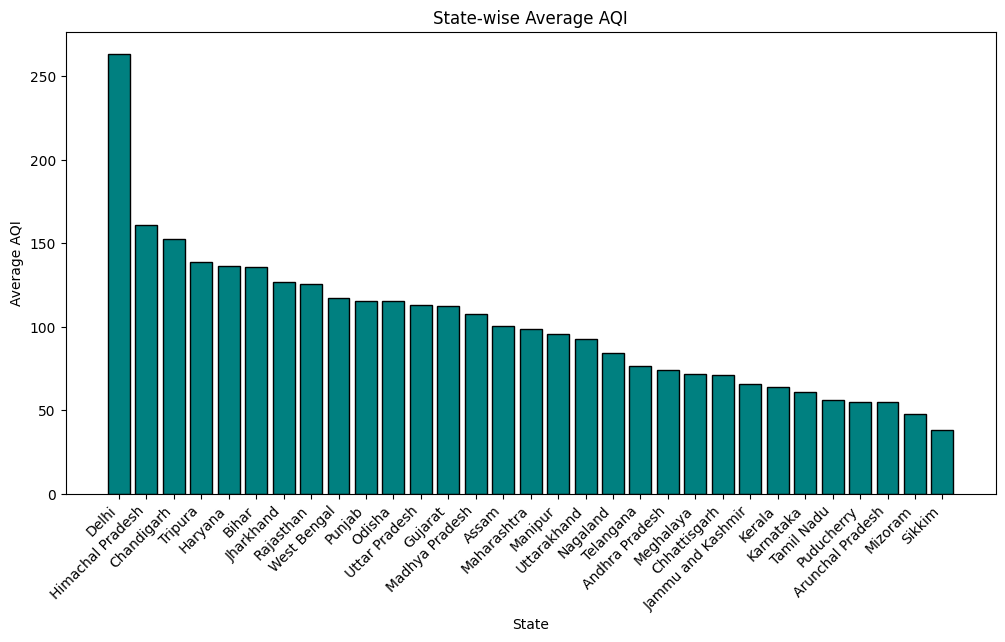

In [6]:
# ------------------ STATE-WISE AVERAGE AQI ------------------
state_avg = df.groupby("STATE")["AQI"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
plt.bar(state_avg.index, state_avg.values, color='teal', edgecolor='black')
plt.title("State-wise Average AQI")
plt.xlabel("State")
plt.ylabel("Average AQI")
plt.xticks(rotation=45, ha='right')
plt.show()

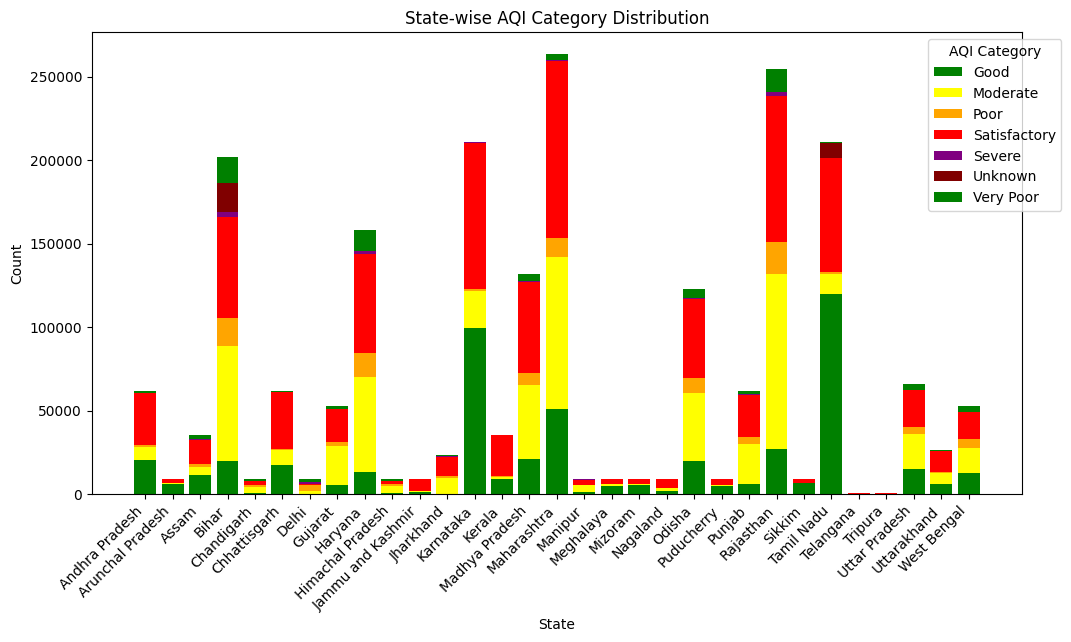

In [7]:
# ------------------ STATE-WISE AQI CATEGORY (STACKED BAR) ------------------
state_category = df.groupby(["STATE","AQI_CATEGORY"]).size().unstack().fillna(0)
states = state_category.index
categories = state_category.columns

plt.figure(figsize=(12,6))
bottom_values = [0]*len(states)
colors = ['green','yellow','orange','red','purple','maroon']
for i, cat in enumerate(categories):
    plt.bar(states, state_category[cat], bottom=bottom_values, label=cat, color=colors[i % len(colors)])
    bottom_values = [sum(x) for x in zip(bottom_values, state_category[cat])]
plt.title("State-wise AQI Category Distribution")
plt.xlabel("State")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="AQI Category", bbox_to_anchor=(1.05,1))
plt.show()

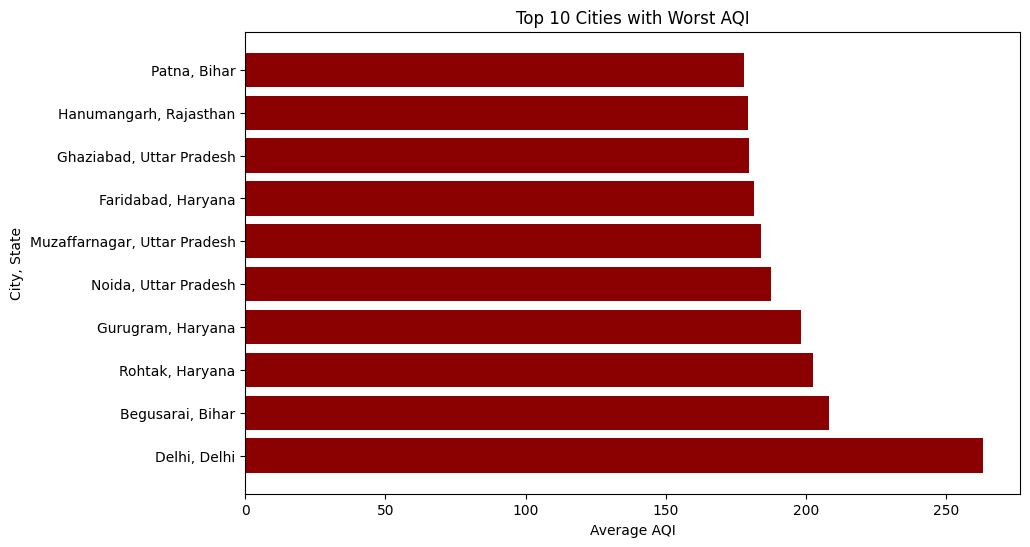

In [8]:
# ------------------ TOP 10 MOST POLLUTED CITIES ------------------
city_avg = df.groupby(["CITY","STATE"])["AQI"].mean().sort_values(ascending=False).head(10)

# Convert MultiIndex to single string for plotting
city_labels = [f"{city}, {state}" for city, state in city_avg.index]

plt.figure(figsize=(10,6))
plt.barh(city_labels, city_avg.values, color='darkred')
plt.title("Top 10 Cities with Worst AQI")
plt.xlabel("Average AQI")
plt.ylabel("City, State")
#plt.gca().invert_yaxis()
plt.show()

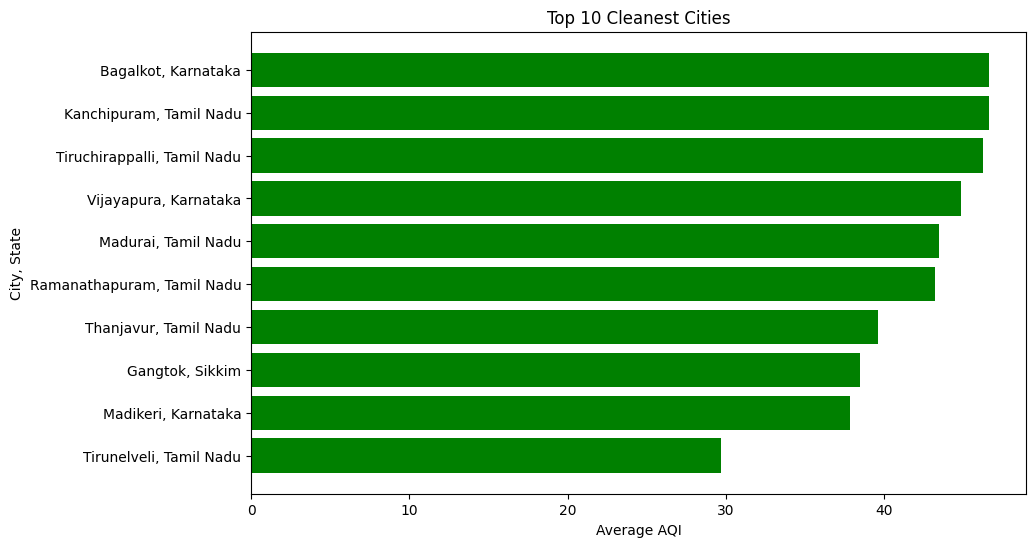

In [9]:
# ------------------ TOP 10 CLEANEST CITIES ------------------
clean_avg = df.groupby(["CITY","STATE"])["AQI"].mean().sort_values().head(10)
clean_labels = [f"{city}, {state}" for city, state in clean_avg.index]

plt.figure(figsize=(10,6))
plt.barh(clean_labels, clean_avg.values, color='green')
plt.title("Top 10 Cleanest Cities")
plt.xlabel("Average AQI")
plt.ylabel("City, State")
#plt.gca().invert_yaxis()
plt.show()

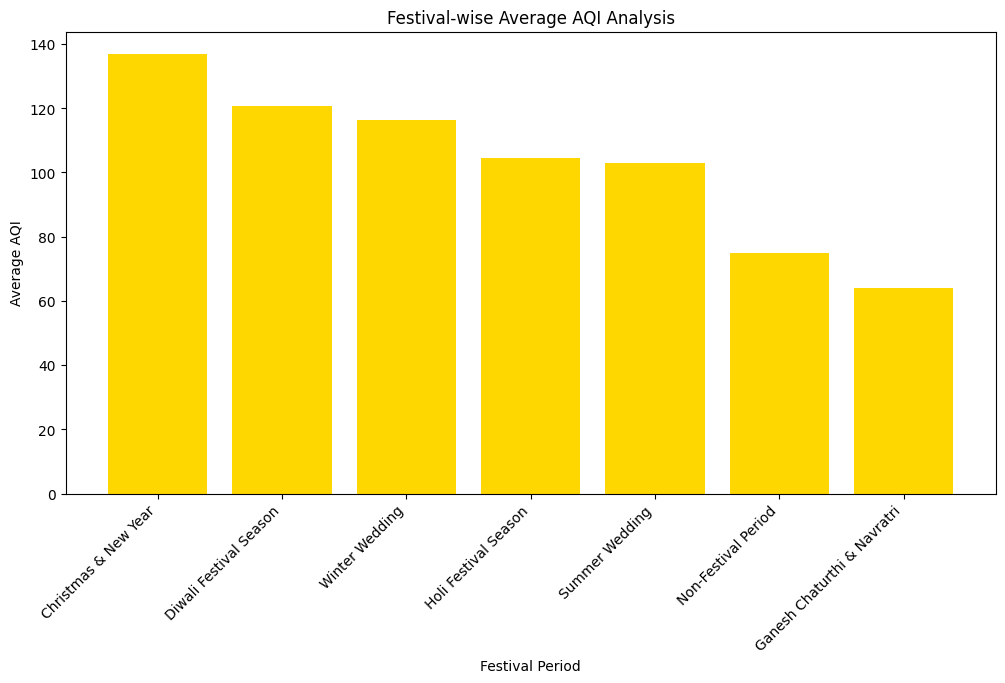

In [10]:
# ------------------ FESTIVAL-WISE AQI ------------------
festival_avg = df.groupby("FESTIVAL_SEASON")["AQI"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
plt.bar(festival_avg.index, festival_avg.values, color='gold')
plt.title("Festival-wise Average AQI Analysis")
plt.xlabel("Festival Period")
plt.ylabel("Average AQI")
plt.xticks(rotation=45, ha='right')
plt.show()

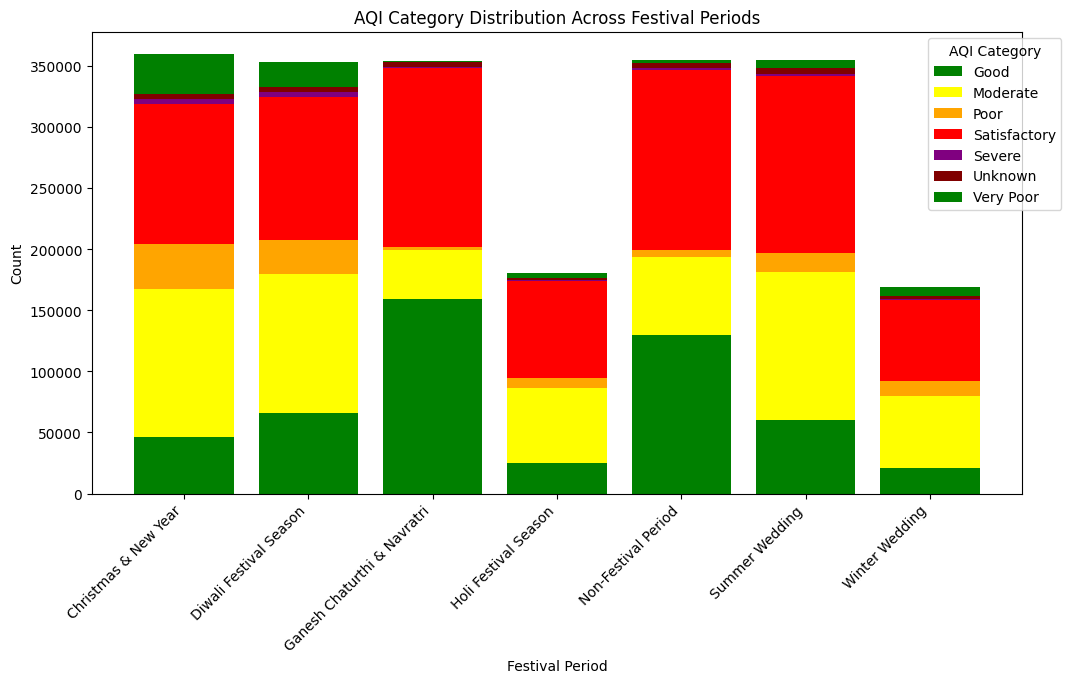

In [11]:
festival_counts = df.groupby(["FESTIVAL_SEASON","AQI_CATEGORY"]).size().unstack().fillna(0)
plt.figure(figsize=(12,6))
bottom = [0]*len(festival_counts)
colors = ['green','yellow','orange','red','purple','maroon']
for i, cat in enumerate(festival_counts.columns):
    plt.bar(festival_counts.index, festival_counts[cat], bottom=bottom, label=cat, color=colors[i % len(colors)])
    bottom = [sum(x) for x in zip(bottom, festival_counts[cat])]
plt.title("AQI Category Distribution Across Festival Periods")
plt.xlabel("Festival Period")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="AQI Category", bbox_to_anchor=(1.05,1))
plt.show()